In [356]:
import math
from random import random

import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import torch
from tqdm import tqdm

In [357]:
n = 10
all_cpgs = []

alpha_w = 1
alpha_psi = 1
alpha_omega = 1
alpha_A = 1
alpha_B = 1
alpha_a = 1
beta_a = 1
alpha_b = 1
beta_b = 1


class CPG:
    def __init__(self, id: int):
        self.id = id

        self.phi = random() * 2 * math.pi
        self.phi_d = 0

        self.a = 0
        self.a_d = 0
        self.a_dd = 0

        self.b = 0
        self.b_d = 0
        self.b_dd = 0

    def forward(self, w, psi, omega, A, B):
        """
        w: (n, n)  Symmetric 0-1
        psi: (n, n)  Skew Symmetric 0-pi
        omega: (n,)  0-1
        A: (n,)  0-1
        B: (n,)  0-1
        return y: (n,)
        """

        i = self.id
        dt = 0.05

        diffs = []
        for j in range(n):
            if i != j:
                other = all_cpgs[j]
                diff = (
                        other.a
                        * alpha_w * w[i, j]
                        * math.sin(
                    other.phi
                    - self.phi
                    - alpha_psi * psi[i][j]
                )
                )
                diffs.append(diff)

        phi_d = alpha_omega * omega[i] + sum(diffs)
        phi = self.phi + self.phi_d * dt

        a_dd = alpha_a * (beta_a * (alpha_A * A[i] - self.a) - self.a_d)
        a_d = self.a_d + self.a_dd * dt
        a = self.a + self.a_d * dt

        b_dd = alpha_b * (beta_b * (alpha_B * B[i] - self.b) - self.b_d)
        b_d = self.b_d + self.b_dd * dt
        b = self.b + self.b_d * dt

        y = b + a * math.sin(phi)

        self.phi = phi
        self.phi_d = phi_d

        self.a = a
        self.a_d = a_d
        self.a_dd = a_dd

        self.b = b
        self.b_d = b_d
        self.b_dd = b_dd

        return y


psi = np.zeros((n, n))  # [0, 2pi]
omega = np.random.rand(n)
A = np.random.rand(n)
B = np.random.rand(n)
w = to_symmetric_upper(torch.rand(n, n)).numpy() * 0.5  # [0-1]

In [358]:
all_cpgs = []
for i in range(n):
    cpg = CPG(i)
    cpg.phi = (30 * i) % 360
    all_cpgs.append(cpg)

ys = [[] for _ in range(n)]
for iteration in tqdm(range(5000)):
    # w = np.random.rand(n, n)  # [0-1]
    # omega = np.random.rand(n)
    # A = np.random.rand(n)
    # B = np.random.rand(n)
    for i, cpg in enumerate(all_cpgs):
        y = cpg.forward(w, psi, omega, A, B)
        ys[i].append(y)

100%|██████████| 5000/5000 [00:00<00:00, 13442.70it/s]


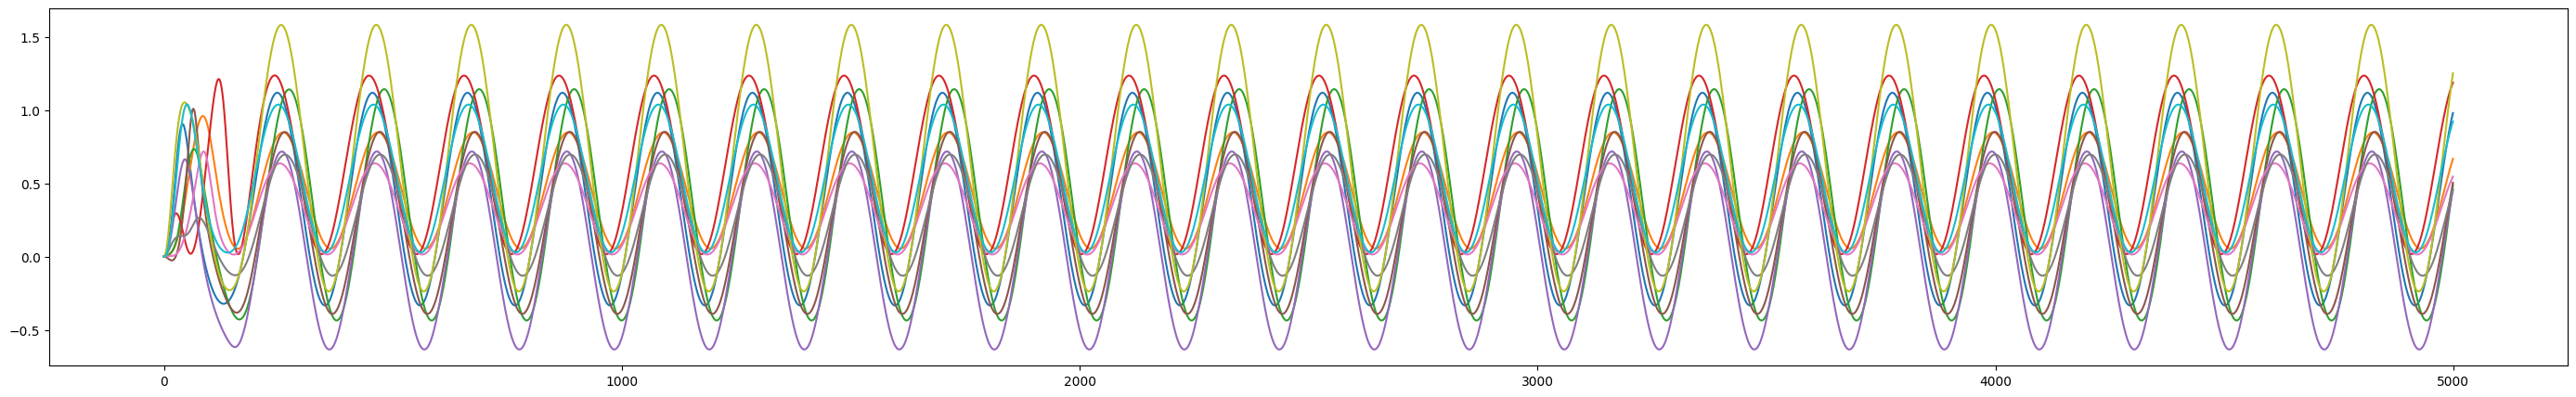

In [359]:
plt.figure(figsize=(35, 5))
for y in ys:
    plt.plot(y)

In [360]:
# ys[0], len(ys[0])

In [361]:
def to_symmetric_upper(x, skew=False):
    n, m = x.shape
    assert n == m

    i, j = torch.triu_indices(n, n, offset=1)  # Get indices of upper triangle
    skew = -1 if skew else 1
    x.T[i, j] = x[i, j] * skew  # Update the lower triangle with upper values.
    x = x * (1 - torch.eye(n))  # Set diagonal to 0

    return x


class KuramotoCPG(nn.Module):
    def __init__(
            self,
            n_cpgs,
            dt=0.05,
            alpha_w=1,
            alpha_psi=1,
            alpha_omega=1,
            alpha_A=1,
            alpha_B=1,
            alpha_a=1,
            beta_a=1,
            alpha_b=1,
            beta_b=1,
    ):
        super().__init__()
        self.dt = dt
        self.n_cpgs = n_cpgs

        # Co-effs
        self.c_w = alpha_w
        self.c_psi = alpha_psi
        self.c_omega = alpha_omega
        self.c_A = alpha_A
        self.c_B = alpha_B
        self.c_a = alpha_a
        self.beta_a = beta_a
        self.c_b = alpha_b
        self.beta_b = beta_b

        # Params
        self.phi = nn.Parameter(torch.rand(n_cpgs) * 2 * math.pi)
        self.phi_d = nn.Parameter(torch.zeros_like(self.phi))

        self.a = nn.Parameter(torch.zeros_like(self.phi))
        self.a_d = nn.Parameter(torch.zeros_like(self.phi))
        self.a_dd = nn.Parameter(torch.zeros_like(self.phi))

        self.b = nn.Parameter(torch.zeros_like(self.phi))
        self.b_d = nn.Parameter(torch.zeros_like(self.phi))
        self.b_dd = nn.Parameter(torch.zeros_like(self.phi))

    def forward(self, w, psi, omega, A, B):
        """
        w: (n, n)  Symmetric
        psi: (n, n)  Skew Symmetric
        omega: (n,)
        A: (n,)
        B: (n,)
        return y: (n,)
        """
        # TODO: Dude, you forgot batch dimension :facepalm:

        w = to_symmetric_upper(w)  # (n, n)
        psi = to_symmetric_upper(psi, skew=True)  # (n, n)

        a_j = self.a.unsqueeze(0).expand(self.n_cpgs, self.n_cpgs)  # (n, n)
        phi_i, phi_j = torch.meshgrid(self.phi, self.phi)

        phi_d = self.c_omega * omega + (a_j * self.c_w * w * torch.sin(phi_j - phi_i - self.c_psi * psi)).sum(axis=1)
        phi = self.phi + self.phi_d * self.dt

        a_dd = alpha_a * (beta_a * (alpha_A * A[i] - self.a) - self.a_d)
        a_d = self.a_d + self.a_dd * self.dt
        a = self.a + self.a_d * self.dt

        b_dd = alpha_b * (beta_b * (alpha_B * B[i] - self.b) - self.b_d)
        b_d = self.b_d + self.b_dd * self.dt
        b = self.b + self.b_d * self.dt

        y = b + a * torch.sin(phi)

        # Updating state
        self.phi.data = phi
        self.phi_d.data = phi_d

        self.a.data = a
        self.a_d.data = a_d
        self.a_dd.data = a_dd

        self.b.data = b
        self.b_d.data = b_d
        self.b_dd.data = b_dd

        return y

100%|██████████| 500/500 [00:00<00:00, 5644.86it/s]


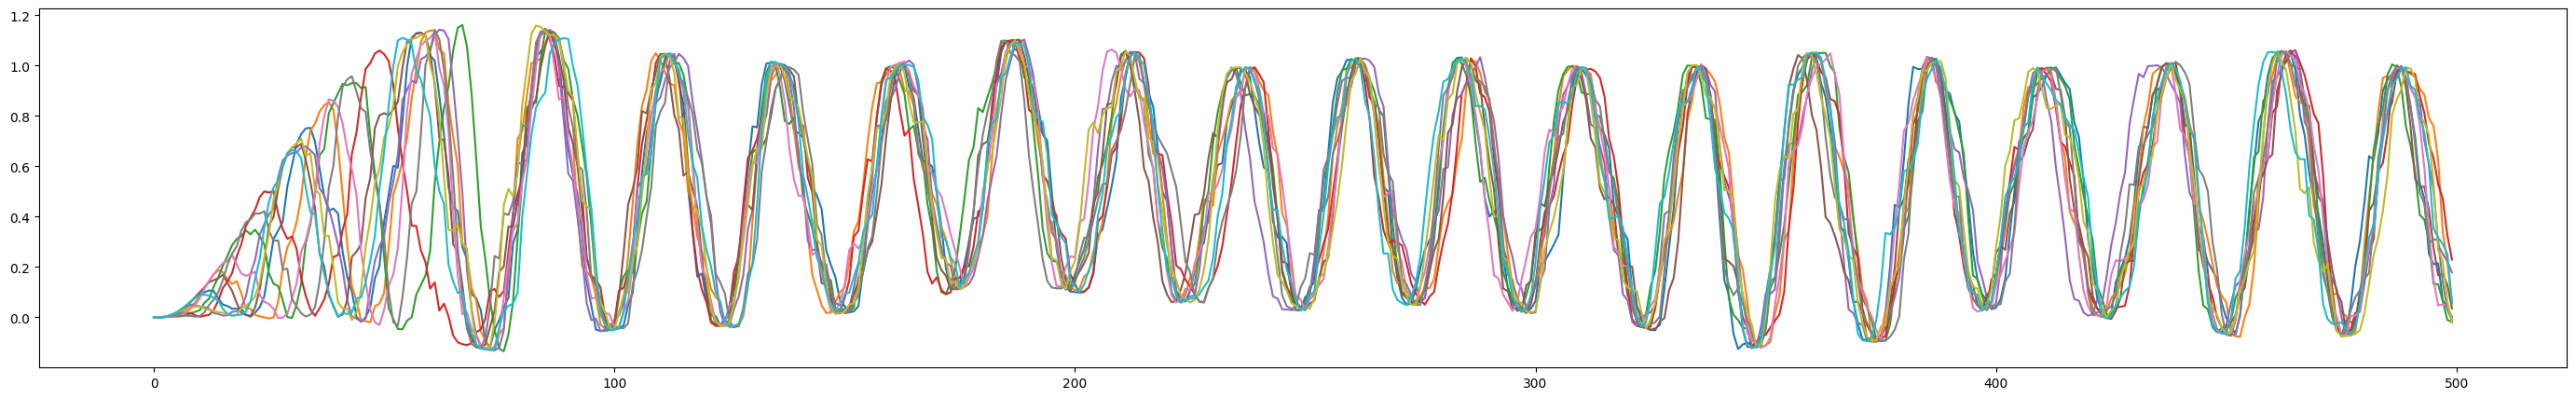

In [362]:
cpg_layer = KuramotoCPG(n_cpgs=n)
cpg_layer.phi.data = torch.tensor([(30 * i) % 360 for i in range(n)], dtype=torch.float32, requires_grad=True)

ys = []
for iteration in tqdm(range(500)):
    w = np.random.rand(n, n)  # [0-1]
    omega = np.random.rand(n) * 10
    A = np.random.rand(n)
    B = np.random.rand(n)

    y = cpg_layer(
        w=torch.tensor(w),
        psi=torch.tensor(psi),
        omega=torch.tensor(omega),
        A=torch.tensor(A),
        B=torch.tensor(B),
    )
    ys.append(y.tolist())
ys = np.array(ys).T
plt.figure(figsize=(35, 5))
for y in ys:
    plt.plot(y)

In [363]:
# ys[0].tolist()

In [364]:
x = torch.randint(low=0, high=9, size=(5, 5))
x

tensor([[0, 8, 8, 5, 7],
        [1, 1, 8, 0, 4],
        [8, 3, 4, 1, 2],
        [1, 1, 5, 4, 1],
        [5, 4, 6, 8, 2]])

In [365]:
i, j = torch.meshgrid(x[0], x[0])
i, j

(tensor([[0, 0, 0, 0, 0],
         [8, 8, 8, 8, 8],
         [8, 8, 8, 8, 8],
         [5, 5, 5, 5, 5],
         [7, 7, 7, 7, 7]]),
 tensor([[0, 8, 8, 5, 7],
         [0, 8, 8, 5, 7],
         [0, 8, 8, 5, 7],
         [0, 8, 8, 5, 7],
         [0, 8, 8, 5, 7]]))

In [366]:
i - j

tensor([[ 0, -8, -8, -5, -7],
        [ 8,  0,  0,  3,  1],
        [ 8,  0,  0,  3,  1],
        [ 5, -3, -3,  0, -2],
        [ 7, -1, -1,  2,  0]])

In [367]:
torch.sin(i - j)

tensor([[ 0.0000, -0.9894, -0.9894,  0.9589, -0.6570],
        [ 0.9894,  0.0000,  0.0000,  0.1411,  0.8415],
        [ 0.9894,  0.0000,  0.0000,  0.1411,  0.8415],
        [-0.9589, -0.1411, -0.1411,  0.0000, -0.9093],
        [ 0.6570, -0.8415, -0.8415,  0.9093,  0.0000]])

In [368]:
w = to_symmetric_upper(torch.randint(low=0, high=9, size=(5, 5))).int()
w

tensor([[0, 0, 7, 4, 5],
        [0, 0, 5, 4, 2],
        [7, 5, 0, 5, 4],
        [4, 4, 5, 0, 4],
        [5, 2, 4, 4, 0]], dtype=torch.int32)

In [369]:
psi = to_symmetric_upper(torch.rand(size=(5, 5)) * math.pi, skew=True)
psi

tensor([[ 0.0000,  2.3613,  2.2965,  1.6256,  2.2159],
        [-2.3613,  0.0000,  1.6930,  0.8483,  2.0030],
        [-2.2965, -1.6930,  0.0000,  3.0501,  2.4545],
        [-1.6256, -0.8483, -3.0501,  0.0000,  2.3508],
        [-2.2159, -2.0030, -2.4545, -2.3508,  0.0000]])

In [370]:
phi = torch.randint(low=0, high=9, size=(5,))
phi

tensor([7, 3, 7, 7, 3])

In [371]:
a = torch.randint(low=0, high=9, size=(5,))
a

tensor([3, 4, 8, 0, 5])

In [372]:
omega = torch.randint(low=0, high=9, size=(5,))
omega

tensor([4, 5, 3, 1, 0])

In [373]:
phi_i, phi_j = torch.meshgrid(phi, phi)
phi_i, phi_j

(tensor([[7, 7, 7, 7, 7],
         [3, 3, 3, 3, 3],
         [7, 7, 7, 7, 7],
         [7, 7, 7, 7, 7],
         [3, 3, 3, 3, 3]]),
 tensor([[7, 3, 7, 7, 3],
         [7, 3, 7, 7, 3],
         [7, 3, 7, 7, 3],
         [7, 3, 7, 7, 3],
         [7, 3, 7, 7, 3]]))

In [374]:
a_j = a.unsqueeze(0).expand(5, 5)
a_j

tensor([[3, 4, 8, 0, 5],
        [3, 4, 8, 0, 5],
        [3, 4, 8, 0, 5],
        [3, 4, 8, 0, 5],
        [3, 4, 8, 0, 5]])

In [375]:
omega + (a_j * w * torch.sin(phi_j - phi_i - psi)).sum(axis=1)

tensor([-36.2084,  25.5615,   0.4778,  15.4501,  11.7114])